In [4]:
import sys

sys.path.append("..")  # Adjust path to import from parent directory

from core.DataLoader import DataPreprocessor
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt

MAX_JETS = 4
PLOTS_DIR = f"plots_regression/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

DataProcessor = DataPreprocessor(
    jet_features=[
        "ordered_jet_pt",
        "ordered_jet_e",
        "ordered_jet_phi",
        "ordered_jet_eta",
        "ordered_jet_b_tag",
        "m_l1j",
        "m_l2j",
        "dR_l1j",
        "dR_l2j",
    ],
    lepton_features=["lep_pt", "lep_e", "lep_eta", "lep_phi"],
    jet_truth_label="ordered_event_jet_truth_idx",
    lepton_truth_label="event_lepton_truth_idx",
    global_features=["met_met_NOSYS", "met_phi_NOSYS"],
    max_leptons=2,
    max_jets=MAX_JETS,
    non_training_features=[
        "truth_ttbar_mass",
        "truth_ttbar_pt",
        "N_jets",
        "nu_flows_m_ttbar",
    ],
    regression_targets=["truth_ttbar_mass"],
    event_weight="weight_mc_NOSYS",
)


DataProcessor.load_data(
    "/data/dust/group/atlas/ttreco/full_training.root",
    "reco",
    max_events = 100000,
)
DataProcessor.prepare_data()
truth_ttbar_mass = DataProcessor.get_feature_data(
    "non_training", "truth_ttbar_mass"
).reshape(-1, 1)
nu_flows_m_ttbar = DataProcessor.get_feature_data(
    "non_training", "nu_flows_m_ttbar"
).reshape(-1, 1)
weights = DataProcessor.get_event_weight().reshape(-1, 1)
DataProcessor.normalise_data()
DataProcessor.split_data(0.2)

In [ ]:
import core.RegressiontTransformer as TMR
import core.RegressionKFold as RKF

reload(RKF)
reload(TMR)
hidden_size = 16
embedding_layers = 1
attention_blocks = 2
attention_heads = 8


transformer = RKF.RegressionKFold(
    TMR.RegressionTransformer, data_processor=DataProcessor, n_folds=5, n_splits=4
)
if 0:
    transformer.build_models(
        hidden_size=hidden_size,
        lep_dim=6,
        global_dim=3,
        jet_embedding_layers=embedding_layers,
        lepton_embedding_layers=embedding_layers,
        global_embedding_layers=embedding_layers,
        attention_blocks=attention_blocks,
        ff_layers=2,
        n_heads=attention_heads,
    )

# transformer = TMR.RegressionTransformer(DataProcessor); transformer.load_data(*DataProcessor.get_data())
# transformer.compute_sample_weights()
# transformer.compile_models(optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = {"assignment_output": "accuracy", "regression_output": "mse"}),
transformer.load_model(
    "/data/dust/group/atlas/ttreco/CONDOR/plots_RegTransformer_hpo/32_2_2_4_1_0.05_0.001/jet_matcher.keras"
)
# plt.scatter(transformer.X_train["regression_targets"],transformer.sample_weights)

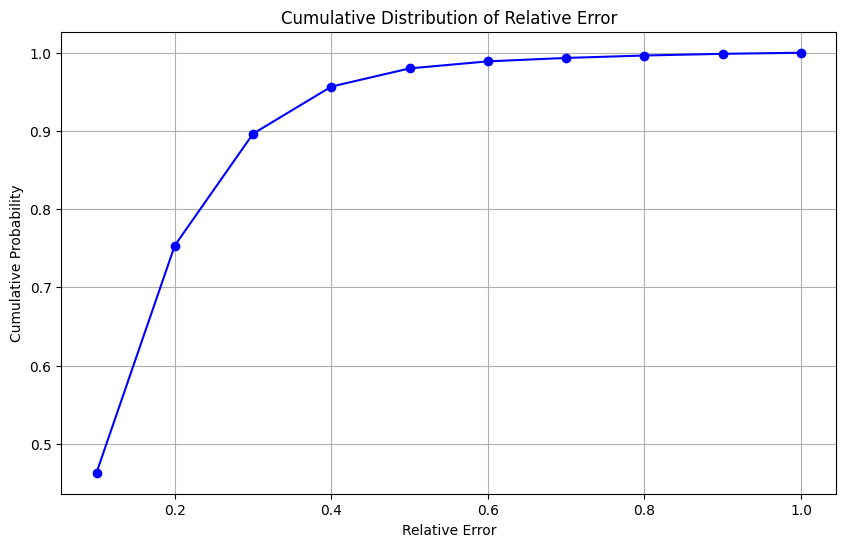

In [5]:
hist, edges = np.histogram(np.abs(nu_flows_m_ttbar - truth_ttbar_mass ) / truth_ttbar_mass, bins=10, range=(0, 1))
cum_hist = np.cumsum(hist)

cum_hist = cum_hist / cum_hist[-1]  # Normalize to get cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(edges[1:], cum_hist, marker='o', linestyle='-', color='blue')
plt.title('Cumulative Distribution of Relative Error')
plt.xlabel('Relative Error')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.savefig(f"{PLOTS_DIR}/cumulative_distribution_relative_error.png")

In [ ]:
np.mean(np.abs(nu_flows_m_ttbar - truth_ttbar_mass) / truth_ttbar_mass)

In [ ]:
fig, ax = transformer.plot_binned_regression_accuracy(
    "truth_ttbar_mass", "non_training",bins = 10, xlims=(340e3, 800e3), additional_data_to_plot = {"nu_flows": (truth_ttbar_mass, nu_flows_m_ttbar, truth_ttbar_mass,weights)}
)
ax[1,0].set_xlabel(r"$m(t\overline{t})$ [GeV]")
fig.savefig(PLOTS_DIR + "binned_regression_accuracy.png")

In [ ]:
fig, ax = transformer.plot_relative_variation_histogram()
hist, bin_edges = np.histogram(
    (nu_flows_m_ttbar - truth_ttbar_mass) / truth_ttbar_mass,
    bins=30,
    range=(-1, 1),
    density=True,
)
hist = hist / np.sum(hist)  # Normalize histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Calculate bin centers
ax[0].bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.7, color='tab:orange', label="nu_flows")
ax[0].legend()
fig.savefig(f"{PLOTS_DIR}/relative_variation_histogram.png")

In [ ]:
transformer.evaluate_accuracy()

In [ ]:
fig, ax = transformer.plot_prediction_2d_hist(xlims=(340e3, 800e3), bins = 15)
fig.savefig(f"{PLOTS_DIR}/prediction_2d_hist.png")

In [ ]:
fig, ax = transformer.plot_permutation_importance()
fig.savefig(f"{PLOTS_DIR}/permutation_importance.png")